In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

from math import sqrt
pd.set_option('display.max_columns', None)


Напишем код для метрик:

In [129]:
def MAE(y_test, y_pred):
    return  abs(y_test-y_pred).mean()

def MSE(y_test, y_pred):
    return ((y_test-y_pred)**2).mean()

def RMSE(y_test, y_pred):
    return sqrt( MSE(y_test,y_pred) )

def MAPE(y_test, y_pred):
    return  (abs(y_test-y_pred) / abs(y_test)).mean()
def R2(y_test, y_pred):
      return  1 - MSE(y_test, y_pred)/ ((y_test- y_test.mean())**2).mean()

# Импорт датасета

In [130]:
data=pd.read_csv('../data/moldova_cars_task.csv')
data

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
...,...,...,...,...,...,...,...,...,...
41002,Dacia,NaN,2015.0,Universal,89000.0,1500.0,Diesel,Manual,7000.0
41003,Renault,Modus,2009.0,Hatchback,225.0,1500.0,Diesel,Manual,4500.0
41004,Mercedes,E Class,2016.0,Sedan,50000.0,1950.0,Diesel,Automatic,29500.0
41005,Mazda,6,2006.0,Combi,370000.0,2000.0,Diesel,Manual,4000.0


## 1.Data preprocesing

Получим информацию о датасете:

In [131]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41007 entries, 0 to 41006
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  41007 non-null  object 
 1   Model                 40671 non-null  object 
 2   Year                  40771 non-null  float64
 3   Style                 40938 non-null  object 
 4   Distance              40889 non-null  float64
 5   Engine_capacity(cm3)  41007 non-null  float64
 6   Fuel_type             41007 non-null  object 
 7   Transmission          40779 non-null  object 
 8   Price(euro)           41007 non-null  float64
dtypes: float64(4), object(5)
memory usage: 2.8+ MB


<h4>1.1 Форматирование заголовков</h4>

In [132]:
data.columns

Index(['Make', 'Model', 'Year', 'Style', 'Distance', 'Engine_capacity(cm3)',
       'Fuel_type', 'Transmission', 'Price(euro)'],
      dtype='object')

Сделаем названия колонок более удобными в работе(уберем излишнее описание):

In [133]:
data=data.rename(
    columns={
        'Engine_capacity(cm3)':'Engine_capacity',
        'Price(euro)':'Price'
    }
)

In [134]:
data.columns

Index(['Make', 'Model', 'Year', 'Style', 'Distance', 'Engine_capacity',
       'Fuel_type', 'Transmission', 'Price'],
      dtype='object')

<h4>1.2 Сброс пропущенных значений</h4>

In [135]:
data.isna().sum()

Make                 0
Model              336
Year               236
Style               69
Distance           118
Engine_capacity      0
Fuel_type            0
Transmission       228
Price                0
dtype: int64

Всего в таблице околок 41 тысячи объектов ,поэтому лучше отбросить незначительное количество объектов,чем заполнять по моде.

In [136]:
data=data.dropna()

In [137]:
data

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price
0,Toyota,Prius,2011.0,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
...,...,...,...,...,...,...,...,...,...
41001,Land Rover,Freelander,2002.0,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
41003,Renault,Modus,2009.0,Hatchback,225.0,1500.0,Diesel,Manual,4500.0
41004,Mercedes,E Class,2016.0,Sedan,50000.0,1950.0,Diesel,Automatic,29500.0
41005,Mazda,6,2006.0,Combi,370000.0,2000.0,Diesel,Manual,4000.0


<h4>1.3 Дубликаты</h4>

Удалим явные дубликаты:

In [138]:
print(data.duplicated().sum())
data=data.drop_duplicates()
print(data.duplicated().sum())

3589
0


<h4>1.4.Кодирование категориальных признаков<h4/>

In [139]:
copy_data=data.copy()
data=pd.get_dummies(data)


In [140]:
data

,Year,Distance,Engine_capacity,Price,Make_ARO,Make_Abarth,Make_Acura,Make_Alfa Romeo,Make_Alta marca,Make_Aston Martin,Make_Audi,Make_BAIC,Make_BMW,Make_Bentley,Make_Brilliance,Make_Buick,Make_Byd,Make_Cadillac,Make_Changan,Make_Chery,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Datsun,Make_Dodge,Make_Faw,Make_Ferrari,Make_Fiat,Make_Ford,Make_GAZ,Make_GMC,Make_Geely,Make_Great Wall,Make_Groz,Make_Haima,Make_Haval,Make_Honda,Make_Hummer,Make_Hyundai,Make_Infiniti,Make_Isuzu,Make_Jac,Make_Jaguar,Make_Jeep,Make_KIA,Make_Lada,Make_Lamborghini,Make_Lancia,Make_Land Rover,Make_Lexus,Make_Lifan,Make_Lincoln,Make_LuAZ,Make_Maserati,Make_Mazda,Make_McLaren,Make_Mercedes,Make_Mercedes-Maybach,Make_Mini,Make_Mitsubishi,Make_Moskvich / Izh,Make_Nissan,Make_Opel,Make_Peugeot,Make_Pontiac,Make_Porsche,Make_Ravon,Make_Renault,Make_Rover,Make_Saab,Make_Saturn,Make_Scion,Make_Seat,Make_Skoda,Make_Smart,Make_Ssangyong,Make_Subaru,Make_Suzuki,Make_Tata,Make_Tesla,Make_Toyota,Make_UAZ,Make_Vaz,Make_Volkswagen,Make_Volvo,Make_Xpeng,Make_Zaz,Make_Zotye,Model_1 Series,Model_100,Model_1007,Model_106,Model_107,Model_108,Model_1102 Tavria,Model_121,Model_145,Model_147,Model_156,Model_159,Model_166,Model_19,Model_190,Model_2,Model_2 Series,Model_200,Model_200 Series,Model_2008,Model_205,Model_206,Model_207,Model_208,Model_21,Model_2101,Model_2102,Model_2103,Model_2104,Model_2105,Model_2106,Model_2107,Model_2108,Model_2109,Model_21099,Model_2110,Model_2111,Model_2112,Model_2113,Model_2114,Model_2115,Model_2121niva,Model_2123 Chevrolet,Model_2125,Model_2129 Niva Long,Model_2140,Model_2141,Model_2410,Model_25,Model_3,Model_3 GT,Model_3 Series,Model_3008,Model_300c,Model_300m,Model_301,Model_306,Model_307,Model_308,Model_309,Model_31029,Model_3110,Model_323,Model_4 series,Model_4-Runner,Model_400 Series,Model_4007,Model_401,Model_405,Model_406,Model_407,Model_408,Model_45,Model_469,Model_5,Model_5 GT,Model_5 Series,Model_500,Model_5008,Model_500L,Model_508,Model_6,Model_6 Series,Model_600 Series,Model_605,Model_607,Model_620,Model_626,Model_7 Series,Model_700 Series,Model_75,Model_8 Series,Model_80,Model_800 Series,Model_806,Model_807,Model_9-3,Model_9-5,Model_90,Model_900 Series,Model_9000,Model_911,Model_924,Model_929,Model_968,Model_969,Model_A Class,Model_A1,Model_A2,Model_A3,Model_A3 e-tron,Model_A4,Model_A5,Model_A6,Model_A7,Model_A8,Model_AMG GT,Model_ASX,Model_ATS,Model_Accent,Model_Accord,Model_Actyon,Model_Adam,Model_Aerostar,Model_Agila,Model_Albea,Model_Alhambra,Model_Allroad,Model_Almera,Model_Almera Tino,Model_Alt model,Model_Altea,Model_Altea XL,Model_Altele,Model_Altima,Model_Alto,Model_Amarok,Model_Ampera,Model_Antara,Model_Applouse,Model_Arosa,Model_Arteon,Model_Ascona,Model_Astra,Model_Atos,Model_Auris,Model_Avalanche,Model_Avalon,Model_Avante,Model_Avenger,Model_Avensis,Model_Avensis Verso,Model_Aventador,Model_Aveo,Model_Ax,Model_Aygo,Model_Azera,Model_B Class,Model_B-Max,Model_B9 Tribeca,Model_BRZ,Model_BS3,Model_BS6,Model_BT-50,Model_BX,Model_Baleno,Model_Beetle,Model_Berlingo,Model_Bipper,Model_Blazer,Model_Bls,Model_Bluebird,Model_Bolt,Model_Bora,Model_Boxster,Model_Brava,Model_Bravo,Model_Breez,Model_C Class,Model_C-Class Coupe,Model_C-Crosser,Model_C-Elysee,Model_C-HR,Model_C-Max,Model_C1,Model_C2,Model_C3,Model_C3 Picasso,Model_C30,Model_C4,Model_C4 Cactus,Model_C4 Picasso,Model_C5,Model_C70,Model_C8,Model_CK,Model_CL Class,Model_CLA,Model_CLC Class,Model_CLK Class,Model_CLS Class,Model_CR-V,Model_CR-Z,Model_CS35PLUS,Model_CT Series,Model_CTS,Model_CX,Model_CX-3,Model_CX-30,Model_CX-5,Model_CX-7,Model_CX-9,Model_Caddy,Model_Caliber,Model_Calibra,Model_Camaro,Model_Camry,Model_Captiva,Model_Captur,Model_Caravan,Model_Caravelle,Model_Carens,Model_Carina,Model_Carisma,Model_Carnival,Model_Cayenne,Model_Cayenne Coupe,Model_Cayman,Model_Ceed,Model_Ceed Sw,Model_Celica,Model_Cerato,Model_Challenger,Model_Charger,Model_Cherokee,Model_Cherry,Model_Chery Van,Model_Citan,Model_Citigo,Model_City K-ZE,M

## 2.EDA

In [141]:
data.describe()

Year      Distance  Engine_capacity         Price  \
count  36441.000000  3.644100e+04     36441.000000  3.644100e+04   
mean    2007.723059  4.759444e+05      1859.135123  9.589220e+03   
std        8.287601  4.582778e+06       707.513603  5.340259e+04   
min     1900.000000  0.000000e+00         0.000000  1.000000e+00   
25%     2004.000000  9.000000e+04      1499.000000  3.333000e+03   
50%     2009.000000  1.700000e+05      1800.000000  6.499000e+03   
75%     2014.000000  2.300000e+05      2000.000000  1.180000e+04   
max     2021.000000  1.000000e+08      9999.000000  1.000000e+07   

           Make_ARO   Make_Abarth    Make_Acura  Make_Alfa Romeo  \
count  36441.000000  36441.000000  36441.000000     36441.000000   
mean       0.000055      0.000027      0.000384         0.001153   
std        0.007408      0.005238      0.019597         0.033930   
min        0.000000      0.000000      0.000000         0.000000   
25%        0.000000      0.000000      0.000000         0.000000   
50%        0.000000      0.000000      0.000000         0.000000   
75%        0.000000      0.000000      0.000000         0.000000   
max        1.000000      1.000000      1.000000         1.000000   

       Make_Alta marca  Make_Aston Martin     Make_Audi     Make_BAIC  \
count     36441.000000       36441.000000  36441.000000  36441.000000   
mean          0.000686           0.000027      0.048187      0.000082   
std           0.026184           0.005238      0.214165      0.009073   
min           0.000000           0.000000      0.000000      0.000000   
25%           0.000000           0.000000      0.000000      0.000000   
50%           0.000000           0.000000      0.000000      0.000000   
75%           0.000000           0.000000      0.000000      0.000000   
max           1.000000           1.000000      1.000000      1.000000   

           Make_BMW  Make_Bentley  Make_Brilliance    Make_Buick  \
count  36441.000000  36441.000000     36441.000000  36441.000000   
mean       0.080514      0.000137         0.000439      0.000137   
std        0.272091      0.011713         0.020950      0.011713   
min        0.000000      0.000000         0.000000      0.000000   
25%        0.000000      0.000000         0.000000      0.000000   
50%        0.000000      0.000000         0.000000      0.000000   
75%        0.000000      0.000000         0.000000      0.000000   
max        1.000000      1.000000         1.000000      1.000000   

           Make_Byd  Make_Cadillac  Make_Changan    Make_Chery  \
count  36441.000000   36441.000000  36441.000000  36441.000000   
mean       0.000467       0.000686      0.000110      0.000521   
std        0.021594       0.026184      0.010477      0.022828   
min        0.000000       0.000000      0.000000      0.000000   
25%        0.000000       0.000000      0.000000      0.000000   
50%        0.000000       0.000000      0.000000      0.000000   
75%        0.000000       0.000000      0.000000      0.000000   
max        1.000000       1.000000      1.000000      1.000000   

       Make_Chevrolet  Make_Chrysler  Make_Citroen    Make_Dacia  \
count    36441.000000   36441.000000  36441.000000  36441.000000   
mean         0.009852       0.002607      0.009028      0.040861   
std          0.098766       0.050992      0.094589      0.197970   
min          0.000000       0.000000      0.000000      0.000000   
25%          0.000000       0.000000      0.000000      0.000000   
50%          0.000000       0.000000      0.000000      0.000000   
75%          0.000000       0.000000      0.000000      0.000000   
max          1.000000       1.000000      1.000000      1.000000   

        Make_Daewoo  Make_Daihatsu   Make_Datsun    Make_Dodge      Make_Faw  \
count  36441.000000   36441.000000  36441.000000  36441.000000  36441.000000   
mean       0.002113       0.000851      0.000082      0.001784      0.000055   
std        0.045919       0.029155      0.009073      0.042197      0.

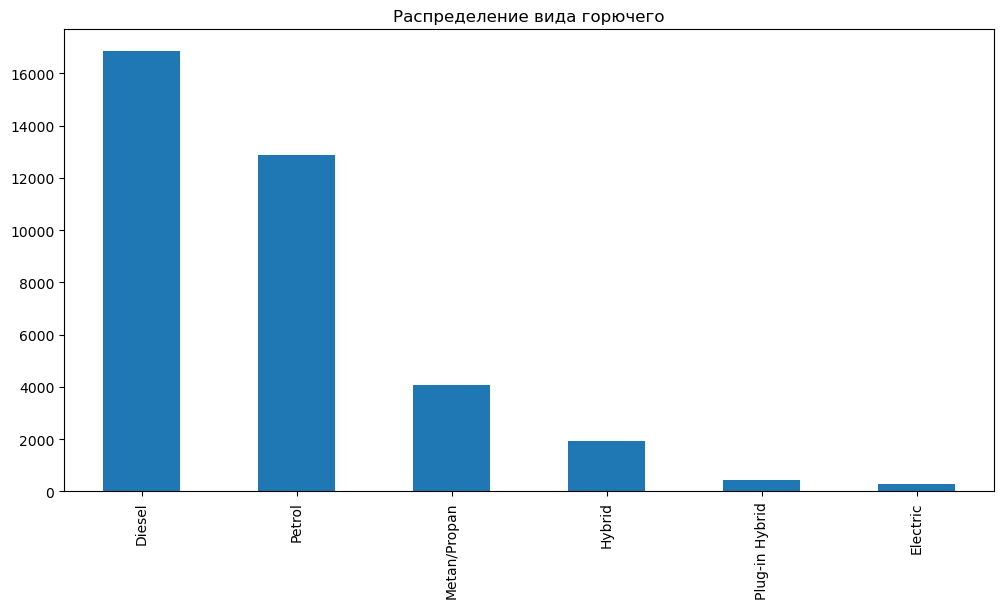

In [142]:
fuel_type_counts = copy_data['Fuel_type'].value_counts()
plt.figure(figsize=(12, 6))
fuel_type_counts.plot(kind='bar')
plt.title('Распределение вида горючего')
plt.xticks(rotation=90)
plt.show()

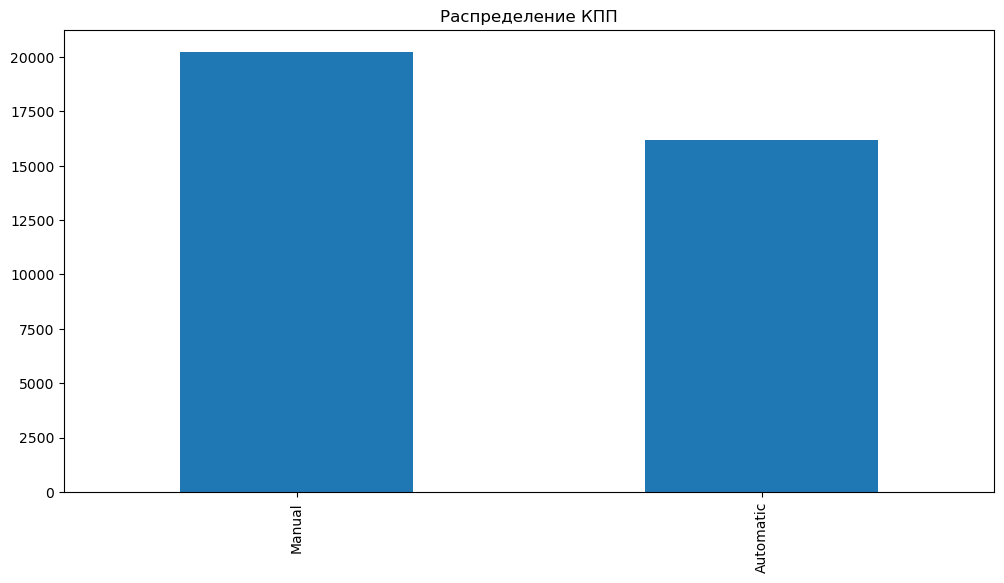

In [143]:
transmission_counts = copy_data['Transmission'].value_counts()
plt.figure(figsize=(12, 6))
transmission_counts.plot(kind='bar')
plt.title('Распределение КПП')
plt.xticks(rotation=90)
plt.show()

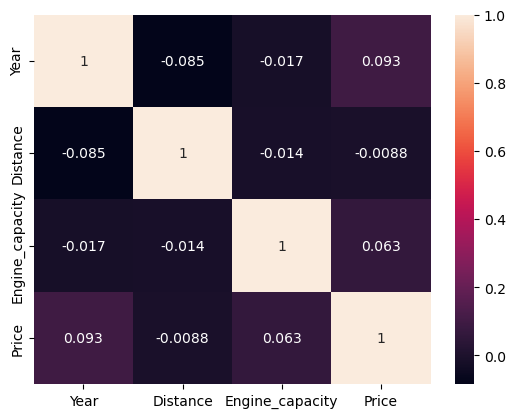

In [144]:
df_num = copy_data.select_dtypes(include=np.number)
df_corr = df_num.corr()
sns.heatmap(df_corr, annot=True);

{'whiskers': [<matplotlib.lines.Line2D at 0x236045f0590>,
 'caps': [<matplotlib.lines.Line2D at 0x23604646890>,
 'boxes': [<matplotlib.lines.Line2D at 0x236045f2290>],
 'medians': [<matplotlib.lines.Line2D at 0x23604671610>],
 'fliers': [<matplotlib.lines.Line2D at 0x23604672f90>],
 'means': []}

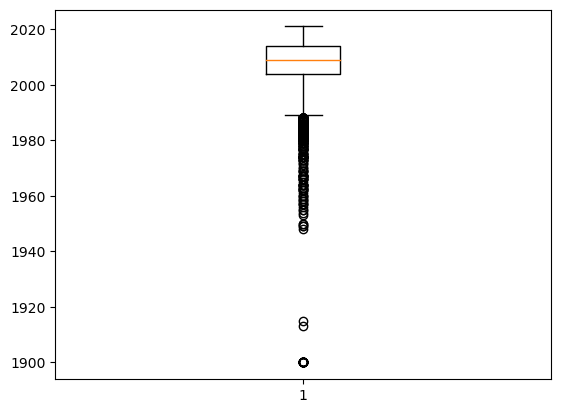

In [145]:
plt.boxplot(copy_data['Year'])

{'whiskers': [<matplotlib.lines.Line2D at 0x23615e5c610>,
 'caps': [<matplotlib.lines.Line2D at 0x23615e5d090>,
 'boxes': [<matplotlib.lines.Line2D at 0x23615e5d790>],
 'medians': [<matplotlib.lines.Line2D at 0x23615e5f210>],
 'fliers': [<matplotlib.lines.Line2D at 0x236006aff50>],
 'means': []}

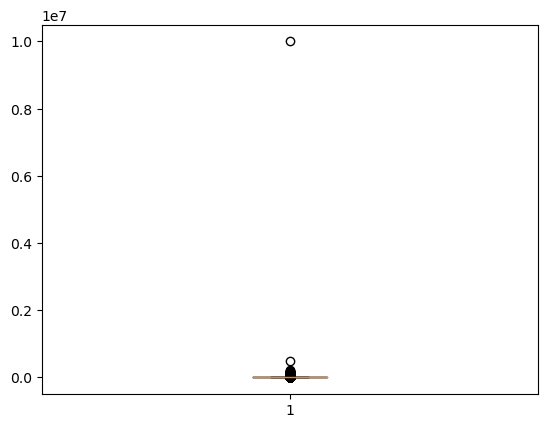

In [146]:
plt.boxplot(copy_data['Price'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2360064d450>,
 'caps': [<matplotlib.lines.Line2D at 0x2360064e410>,
 'boxes': [<matplotlib.lines.Line2D at 0x23615c3ab10>],
 'medians': [<matplotlib.lines.Line2D at 0x2360064e610>],
 'fliers': [<matplotlib.lines.Line2D at 0x2360064ea50>],
 'means': []}

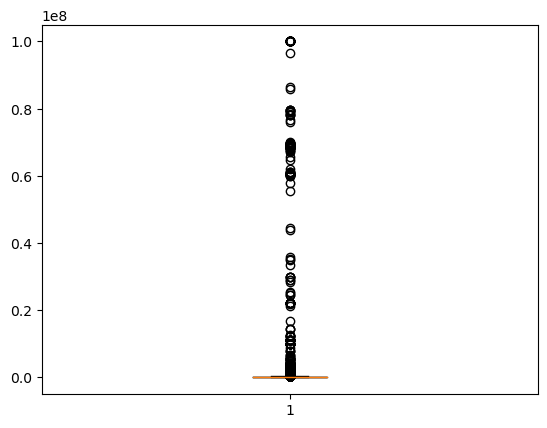

In [147]:
plt.boxplot(copy_data['Distance'])

In [148]:
outlier = data[['Year','Distance','Engine_capacity','Price']]
outlier

,Year,Distance,Engine_capacity,Price
0,2011.0,195000.0,1800.0,7750.0
1,2014.0,135000.0,1500.0,8550.0
2,1998.0,1.0,1400.0,2200.0
3,2012.0,110000.0,1500.0,6550.0
4,2006.0,200000.0,1600.0,4100.0
...,...,...,...,...
41000,2016.0,88000.0,1800.0,11500.0
41001,2002.0,225000.0,1800.0,4400.0
41003,2009.0,225.0,1500.0,4500.0
41005,2006.0,370000.0,2000.0,4000.0


In [149]:
Q1 = outlier.quantile(0.25)
Q1

Year                2004.0
Distance           90000.0
Engine_capacity     1499.0
Price               3333.0
Name: 0.25, dtype: float64

In [150]:
Q3 = outlier.quantile(0.75)
Q3

Year                 2014.0
Distance           230000.0
Engine_capacity      2000.0
Price               11800.0
Name: 0.75, dtype: float64

In [151]:
IQR=Q3-Q1
data_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered

,Year,Distance,Engine_capacity,Price
0,2011.0,195000.0,1800.0,7750.0
1,2014.0,135000.0,1500.0,8550.0
2,1998.0,1.0,1400.0,2200.0
3,2012.0,110000.0,1500.0,6550.0
4,2006.0,200000.0,1600.0,4100.0
...,...,...,...,...
41000,2016.0,88000.0,1800.0,11500.0
41001,2002.0,225000.0,1800.0,4400.0
41003,2009.0,225.0,1500.0,4500.0
41005,2006.0,370000.0,2000.0,4000.0


In [152]:
index_list = list(data_filtered.index.values)
data_filtered = data[data.index.isin(index_list)]
data_filtered

,Year,Distance,Engine_capacity,Price,Make_ARO,Make_Abarth,Make_Acura,Make_Alfa Romeo,Make_Alta marca,Make_Aston Martin,Make_Audi,Make_BAIC,Make_BMW,Make_Bentley,Make_Brilliance,Make_Buick,Make_Byd,Make_Cadillac,Make_Changan,Make_Chery,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Datsun,Make_Dodge,Make_Faw,Make_Ferrari,Make_Fiat,Make_Ford,Make_GAZ,Make_GMC,Make_Geely,Make_Great Wall,Make_Groz,Make_Haima,Make_Haval,Make_Honda,Make_Hummer,Make_Hyundai,Make_Infiniti,Make_Isuzu,Make_Jac,Make_Jaguar,Make_Jeep,Make_KIA,Make_Lada,Make_Lamborghini,Make_Lancia,Make_Land Rover,Make_Lexus,Make_Lifan,Make_Lincoln,Make_LuAZ,Make_Maserati,Make_Mazda,Make_McLaren,Make_Mercedes,Make_Mercedes-Maybach,Make_Mini,Make_Mitsubishi,Make_Moskvich / Izh,Make_Nissan,Make_Opel,Make_Peugeot,Make_Pontiac,Make_Porsche,Make_Ravon,Make_Renault,Make_Rover,Make_Saab,Make_Saturn,Make_Scion,Make_Seat,Make_Skoda,Make_Smart,Make_Ssangyong,Make_Subaru,Make_Suzuki,Make_Tata,Make_Tesla,Make_Toyota,Make_UAZ,Make_Vaz,Make_Volkswagen,Make_Volvo,Make_Xpeng,Make_Zaz,Make_Zotye,Model_1 Series,Model_100,Model_1007,Model_106,Model_107,Model_108,Model_1102 Tavria,Model_121,Model_145,Model_147,Model_156,Model_159,Model_166,Model_19,Model_190,Model_2,Model_2 Series,Model_200,Model_200 Series,Model_2008,Model_205,Model_206,Model_207,Model_208,Model_21,Model_2101,Model_2102,Model_2103,Model_2104,Model_2105,Model_2106,Model_2107,Model_2108,Model_2109,Model_21099,Model_2110,Model_2111,Model_2112,Model_2113,Model_2114,Model_2115,Model_2121niva,Model_2123 Chevrolet,Model_2125,Model_2129 Niva Long,Model_2140,Model_2141,Model_2410,Model_25,Model_3,Model_3 GT,Model_3 Series,Model_3008,Model_300c,Model_300m,Model_301,Model_306,Model_307,Model_308,Model_309,Model_31029,Model_3110,Model_323,Model_4 series,Model_4-Runner,Model_400 Series,Model_4007,Model_401,Model_405,Model_406,Model_407,Model_408,Model_45,Model_469,Model_5,Model_5 GT,Model_5 Series,Model_500,Model_5008,Model_500L,Model_508,Model_6,Model_6 Series,Model_600 Series,Model_605,Model_607,Model_620,Model_626,Model_7 Series,Model_700 Series,Model_75,Model_8 Series,Model_80,Model_800 Series,Model_806,Model_807,Model_9-3,Model_9-5,Model_90,Model_900 Series,Model_9000,Model_911,Model_924,Model_929,Model_968,Model_969,Model_A Class,Model_A1,Model_A2,Model_A3,Model_A3 e-tron,Model_A4,Model_A5,Model_A6,Model_A7,Model_A8,Model_AMG GT,Model_ASX,Model_ATS,Model_Accent,Model_Accord,Model_Actyon,Model_Adam,Model_Aerostar,Model_Agila,Model_Albea,Model_Alhambra,Model_Allroad,Model_Almera,Model_Almera Tino,Model_Alt model,Model_Altea,Model_Altea XL,Model_Altele,Model_Altima,Model_Alto,Model_Amarok,Model_Ampera,Model_Antara,Model_Applouse,Model_Arosa,Model_Arteon,Model_Ascona,Model_Astra,Model_Atos,Model_Auris,Model_Avalanche,Model_Avalon,Model_Avante,Model_Avenger,Model_Avensis,Model_Avensis Verso,Model_Aventador,Model_Aveo,Model_Ax,Model_Aygo,Model_Azera,Model_B Class,Model_B-Max,Model_B9 Tribeca,Model_BRZ,Model_BS3,Model_BS6,Model_BT-50,Model_BX,Model_Baleno,Model_Beetle,Model_Berlingo,Model_Bipper,Model_Blazer,Model_Bls,Model_Bluebird,Model_Bolt,Model_Bora,Model_Boxster,Model_Brava,Model_Bravo,Model_Breez,Model_C Class,Model_C-Class Coupe,Model_C-Crosser,Model_C-Elysee,Model_C-HR,Model_C-Max,Model_C1,Model_C2,Model_C3,Model_C3 Picasso,Model_C30,Model_C4,Model_C4 Cactus,Model_C4 Picasso,Model_C5,Model_C70,Model_C8,Model_CK,Model_CL Class,Model_CLA,Model_CLC Class,Model_CLK Class,Model_CLS Class,Model_CR-V,Model_CR-Z,Model_CS35PLUS,Model_CT Series,Model_CTS,Model_CX,Model_CX-3,Model_CX-30,Model_CX-5,Model_CX-7,Model_CX-9,Model_Caddy,Model_Caliber,Model_Calibra,Model_Camaro,Model_Camry,Model_Captiva,Model_Captur,Model_Caravan,Model_Caravelle,Model_Carens,Model_Carina,Model_Carisma,Model_Carnival,Model_Cayenne,Model_Cayenne Coupe,Model_Cayman,Model_Ceed,Model_Ceed Sw,Model_Celica,Model_Cerato,Model_Challenger,Model_Charger,Model_Cherokee,Model_Cherry,Model_Chery Van,Model_Citan,Model_Citigo,Model_City K-ZE,M

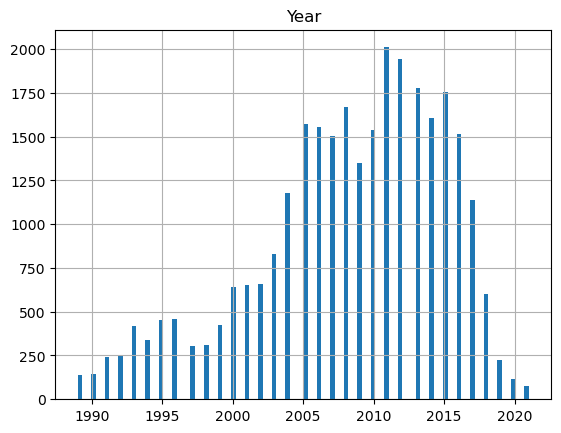

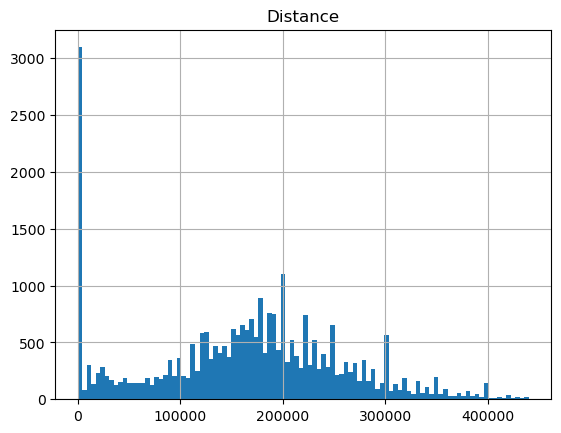

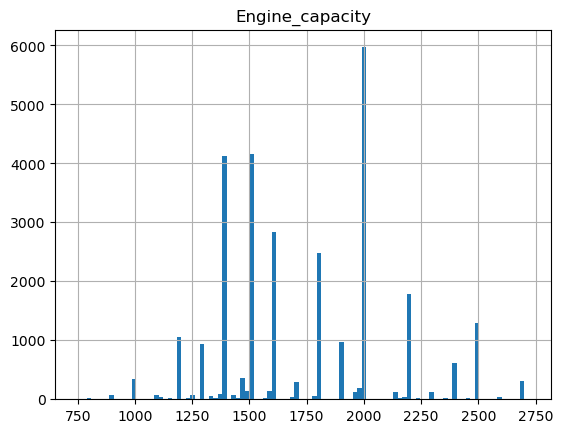

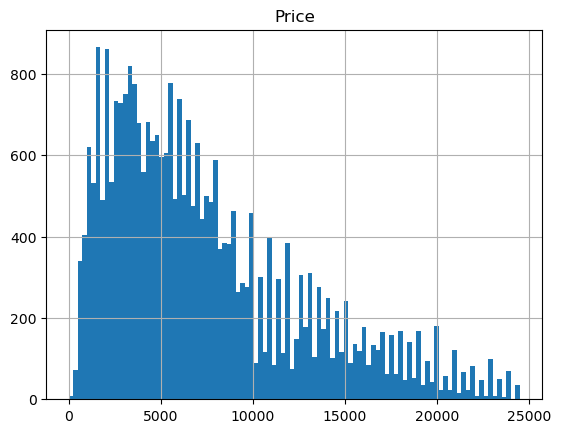

In [153]:
filtered_outlier = data_filtered[['Year','Distance','Engine_capacity','Price']]
for col in filtered_outlier:
    data_filtered.hist(col, bins=100)

## 3. Linear regression 

# 3.1. Simple linear regression:

In [154]:
dict={}
pipeline = Pipeline(
    [
        ('minmaxscaler', MinMaxScaler()),
        ('model', LinearRegression()),
    ]
)
pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('model', LinearRegression())])

In [155]:
y=data_filtered["Price"].values.reshape(-1,1)
X=data_filtered['Year'].values.reshape(-1,1)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
lr1 = pipeline.fit(X_train, y_train)
lr1.predict(X_test)
y_pred = lr1.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr1.score(X_test, y_test)}')

dict['simple lr']=lr1.score(X_test, y_test)

MAE: 2871.9091551330303
MSE: 14019327.475811994
RMSE: 3744.2392385919993
MAPE: 0.8746932778243621
R^2: 0.4769445875745374


# L1(Ridge simple regression):

In [157]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge(alpha=ridge_optimal.best_params_['alpha'])),
    ]
)

In [158]:
ridge1 = pipeline.fit(X_train, y_train)
y_pred = ridge1.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge1.score(X_test, y_test)}')

dict['simple l1']=ridge1.score(X_test, y_test)

MAE: 2871.6115018384667
MSE: 14018723.767701127
RMSE: 3744.1586194632737
MAPE: 0.8743410339713266
R^2: 0.4769671116788825


# L2(Lasso simple regression):

In [159]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
lasso_optimal = RandomizedSearchCV(Lasso(), parameters).fit(X_train, y_train)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso(alpha=lasso_optimal.best_params_['alpha'])),
    ]
)

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+11, tolerance: 5.185e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

In [160]:
lasso1 = pipeline.fit(X_train, y_train)
y_pred = lasso1.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'R^2: {lasso1.score(X_test, y_test)}')

dict['simple l2']=lasso1.score(X_test, y_test)

MAE: 2871.5064381499287
MSE: 14018515.419613833
RMSE: 3744.130796274862
MAPE: 0.7642547815236308
R^2: 0.476974885061373


# Elastic simple regression:

In [161]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
elastic_optimal = RandomizedSearchCV(ElasticNet(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", ElasticNet(elastic_optimal.best_params_['alpha'])),
    ]
)

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e+11, tolerance: 5.185e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

In [162]:
elastic1 = pipeline.fit(X_train, y_train)
y_pred = elastic1.predict(X_test)


print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {elastic1.score(X_test, y_test)}')

dict['simple els']=elastic1.score(X_test, y_test)

MAE: 2871.9091551330293
MSE: 14019327.475811992
RMSE: 3744.239238591999
MAPE: 0.8746932778243615
R^2: 0.4769445875745375


C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+11, tolerance: 6.506e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

# 3.2.Multiple linear regression:

In [163]:
y = data_filtered["Price"]
X = data_filtered.drop(["Price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model",LinearRegression()),
    ]
)

lr2 = pipeline.fit(X_train, y_train)
y_pred = lr2.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr2.score(X_test, y_test)}')

dict['multi lr']=lr2.score(X_test, y_test)

MAE: 32592256725755.61
MSE: 3.322435757792254e+29
RMSE: 576405738850009.6
MAPE: 121405.91127320648
R^2: -1.179171904695738e+22


# L1(Ridge multiple regression):

In [164]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge(alpha=ridge_optimal.best_params_['alpha'])),
    ]
)

In [165]:
ridge2 = pipeline.fit(X_train, y_train)
y_pred = ridge2.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge2.score(X_test, y_test)}')


dict['multi l1']=ridge2.score(X_test, y_test)

MAE: 1743.6814462286886
MSE: 6595692.8993705325
RMSE: 2568.2081106036817
MAPE: 1.255906126989584
R^2: 0.7659110265503826


# L2(Lasso multiple regression):

In [166]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
lasso_optimal = RandomizedSearchCV(Lasso(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Lasso(alpha=lasso_optimal.best_params_['alpha'])),
    ]
)

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.191e+10, tolerance: 5.112e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.394e+10, tolerance: 6.425e+07
  model = cd_fast.enet_coordinate_descent(


In [167]:
lasso2 = pipeline.fit(X_train, y_train)

y_pred = lasso2.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lasso2.score(X_test, y_test)}')

dict['multi l2']=lasso2.score(X_test, y_test)

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.195e+08, tolerance: 6.425e+07
  model = cd_fast.enet_coordinate_descent(


MAE: 1746.322257804536
MSE: 6627033.462445633
RMSE: 2574.3025196051904
MAPE: 1.256677501347721
R^2: 0.7647987127496167


# Elastic net

In [168]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
elastic_optimal = RandomizedSearchCV(ElasticNet(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", ElasticNet(elastic_optimal.best_params_['alpha'])),
    ]
)


C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.191e+10, tolerance: 5.112e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

In [169]:
elastic2 = pipeline.fit(X_train, y_train)
y_pred = elastic2.predict(X_test)


print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {elastic2.score(X_test, y_test)}')

dict['multi els']=elastic2.score(X_test, y_test)

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.579e+10, tolerance: 6.425e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

MAE: 1748.8349526383013
MSE: 6680631.448315632
RMSE: 2584.6917511215206
MAPE: 1.2530115009309821
R^2: 0.7628964565829488


# 3.3. Polynimial regression:

In [170]:
y = data_filtered['Price'].values.reshape(-1,1)
X = data_filtered['Year'].values.reshape(-1,1)

p = PolynomialFeatures(2)

X_p=p.fit_transform(X)
X_p
    
X_train, X_test, y_train, y_test = train_test_split(X_p, y, test_size=0.2)

lr3 = LinearRegression().fit(X_train, y_train)

y_pred = lr3.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lr3.score(X_test, y_test)}')

dict['polinom lr']=lr3.score(X_test, y_test)

MAE: 2503.343979874031
MSE: 11620424.395923192
RMSE: 3408.874359069749
MAPE: 0.7989596804340671
R^2: 0.5788847240432349


# L1 Polynimial regression

In [171]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)
ridge_optimal.best_params_['alpha']

0.0

In [172]:
ridge3 = Ridge(alpha=ridge_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = ridge3.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge3.score(X_test, y_test)}')

dict['polinom l1']=ridge3.score(X_test, y_test)

MAE: 2503.343979879879
MSE: 11620424.395933917
RMSE: 3408.874359071322
MAPE: 0.7989596804474363
R^2: 0.5788847240428463


# L2 Polynimial regression

In [173]:
parameters = {'alpha': np.arange(0, 1, 0.1)}
lasso_optimal = GridSearchCV(Lasso(), parameters).fit(X_train, y_train)
lasso_optimal.best_params_['alpha']

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+11, tolerance: 5.167e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.293e+11, tolerance: 5.173e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+11, tolerance: 5.170e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+11, toleranc

C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+11, tolerance: 5.154e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+11, tolerance: 5.173e+07
  model = cd_fast.enet_coordinate_descent(
C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e+11, toleranc

0.9

In [174]:
lasso3 = Lasso(alpha=lasso_optimal.best_params_['alpha']).fit(X_train, y_train)
y_pred = lasso3.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {lasso3.score(X_test, y_test)}')

dict['polinom l2']=lasso3.score(X_test, y_test)

MAE: 2871.168469449787
MSE: 13932417.856096752
RMSE: 3732.615417652447
MAPE: 0.8666508069971014
R^2: 0.4950998526117921


C:\Users\djego\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e+11, tolerance: 6.460e+07
  model = cd_fast.enet_coordinate_descent(


Найдем максимальное значение регрессии :

In [175]:
x = max(dict, key=dict.get)
print(x)    
print(dict[x])

multi l1
0.7659110265503826


Проверим метрики на multi l1

In [180]:
y = data_filtered["Price"]
X = data_filtered.drop(["Price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

parameters = {'alpha': np.arange(0, 1, 0.1)}
ridge_optimal = RandomizedSearchCV(Ridge(), parameters).fit(X_train, y_train)
pipeline = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("model", Ridge(alpha=ridge_optimal.best_params_['alpha'])),
    ]
)
ridge2 = pipeline.fit(X_train, y_train)
y_pred = ridge2.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, y_pred))}')
print(f'R^2: {ridge2.score(X_test, y_test)}')
print("Мои метрики:")
print(f'MAE: {MAE(y_test, y_pred)}')
print(f'MSE: {MSE(y_test, y_pred)}')
print(f'RMSE: {RMSE(y_test, y_pred)}')
print(f'MAPE: {MAPE(y_test, y_pred)}')
print(f'R^2: {R2(y_test, y_pred)}')



MAE: 1692.944353284838
MSE: 5849304.4750075005
RMSE: 2418.533538119226
MAPE: 1.1554205315148867
R^2: 0.7839092182345191
Мои метрики:
MAE: 1692.944353284838
MSE: 5849304.4750075005
RMSE: 2418.533538119226
MAPE: 1.334996604646143
R^2: 0.7839092182345191
